In [63]:
# Import required libraries
from azure.identity import DefaultAzureCredential
from azure.ai.ml import MLClient

from azure.ai.ml.automl import SearchSpace, ObjectDetectionPrimaryMetrics
from azure.ai.ml.sweep import (
    Choice,
    Uniform,
    BanditPolicy,
)

from azure.ai.ml import automl

In [64]:
credential = DefaultAzureCredential()
ml_client = None
try:
    ml_client = MLClient.from_config(credential)
except Exception as ex:
    print(ex)
    # Enter details of your AML workspace
    subscription_id = "XxXx"
    resource_group = "XxXx"
    workspace = "aml2-ws"
    ml_client = MLClient(credential, subscription_id, resource_group, workspace)

Found the config file in: /config.json


In [ ]:
!pip install azureml-mlflow
!pip install mlflow

In [65]:
import mlflow

# Obtain the tracking URL from MLClient
MLFLOW_TRACKING_URI = ml_client.workspaces.get(
    name=ml_client.workspace_name
).mlflow_tracking_uri

print(MLFLOW_TRACKING_URI)

azureml://eastus.api.azureml.ms/mlflow/v1.0/subscriptions/dcfc206a-203b-4c00-a236-bdf576a37896/resourceGroups/aml-v2-book/providers/Microsoft.MachineLearningServices/workspaces/aml2-ws


In [66]:
# Set the MLFLOW TRACKING URI

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

print("\nCurrent tracking uri: {}".format(mlflow.get_tracking_uri()))


Current tracking uri: azureml://eastus.api.azureml.ms/mlflow/v1.0/subscriptions/dcfc206a-203b-4c00-a236-bdf576a37896/resourceGroups/aml-v2-book/providers/Microsoft.MachineLearningServices/workspaces/aml2-ws


In [67]:
from mlflow.tracking.client import MlflowClient

# Initialize MLFlow client
mlflow_client = MlflowClient()

In [129]:
# Get the AutoML parent Job

job_name = "AutoML_ada7f120-62e2-46fd-8ef7-59cae1106262"


mlflow_parent_run = mlflow_client.get_run(job_name)

print("Parent Run: ")
print(mlflow_parent_run)

In [130]:
# Print parent run tags. 'automl_best_child_run_id' tag should be there.
print(mlflow_parent_run.data.tags)

In [70]:
# Get the best model's child run

best_child_run_id = mlflow_parent_run.data.tags["automl_best_child_run_id"]
print("Found best child run id: ", best_child_run_id)

best_run = mlflow_client.get_run(best_child_run_id)

print("Best child run: ")
print(best_run)

Found best child run id:  AutoML_ada7f120-62e2-46fd-8ef7-59cae1106262_HD_0
Best child run: 
<Run: data=<RunData: metrics={'mean_average_precision': 0.875, 'precision': 0.18924, 'recall': 0.875}, params={}, tags={'hyperparameters': '{"model_name": "yolov5"}',
 'mlflow.parentRunId': 'AutoML_ada7f120-62e2-46fd-8ef7-59cae1106262_HD',
 'mlflow.rootRunId': 'AutoML_ada7f120-62e2-46fd-8ef7-59cae1106262',
 'mlflow.runName': 'placid_dog_clb9whn9',
 'mlflow.source.name': 'hd_object_detection_dnn_driver.py',
 'mlflow.source.type': 'JOB',
 'mlflow.user': 'Sina Fakhraee'}>, info=<RunInfo: artifact_uri='azureml://experiments/playing_cards_experiment/runs/AutoML_ada7f120-62e2-46fd-8ef7-59cae1106262_HD_0/artifacts', end_time=1668747331043, experiment_id='62562a24-6874-47ac-8f6b-fe36e73a1c81', lifecycle_stage='active', run_id='AutoML_ada7f120-62e2-46fd-8ef7-59cae1106262_HD_0', run_name='', run_uuid='AutoML_ada7f120-62e2-46fd-8ef7-59cae1106262_HD_0', start_time=1668746970961, status='FINISHED', user_id='

In [71]:
import pandas as pd

pd.DataFrame(best_run.data.metrics, index=[0]).T

,0
precision,0.18924
recall,0.87500
mean_average_precision,0.87500


In [72]:
# Create local folder
local_dir = "./artifact_downloads"
if not os.path.exists(local_dir):
    os.mkdir(local_dir)

In [131]:
# Download run's artifacts/outputs
local_path = mlflow_client.download_artifacts(
    best_run.info.run_id, "outputs", local_dir
)
print("Artifacts downloaded in: {}".format(local_path))
print("Artifacts: {}".format(os.listdir(local_path)))

In [74]:
import os

# Show the contents of the MLFlow model folder
os.listdir("./artifact_downloads/outputs/mlflow-model")

['artifacts',
 'conda.yaml',
 'MLmodel',
 'python_env.yaml',
 'python_model.pkl',
 'requirements.txt']

In [75]:
# import required libraries
from azure.ai.ml.entities import (
    ManagedOnlineEndpoint,
    ManagedOnlineDeployment,
    Model,
    Environment,
    CodeConfiguration,
    ProbeSettings,
)

In [76]:
# Creating a unique endpoint name with current datetime to avoid conflicts
import datetime

online_endpoint_name = "playing-cards-" + datetime.datetime.now().strftime(
    "%m%d%H%M%f"
)

# create an online endpoint
endpoint = ManagedOnlineEndpoint(
    name=online_endpoint_name,
    description="this is a sample online endpoint for deploying model",
    auth_mode="key",
    tags={"foo": "bar"},
)
print(online_endpoint_name)

playing-cards-11182014325540


In [77]:
ml_client.begin_create_or_update(endpoint).result()

ManagedOnlineEndpoint({'public_network_access': 'Enabled', 'provisioning_state': 'Succeeded', 'scoring_uri': 'https://playing-cards-11182014325540.eastus.inference.ml.azure.com/score', 'openapi_uri': 'https://playing-cards-11182014325540.eastus.inference.ml.azure.com/swagger.json', 'name': 'playing-cards-11182014325540', 'description': 'this is a sample online endpoint for deploying model', 'tags': {'foo': 'bar'}, 'properties': {'azureml.onlineendpointid': '/subscriptions/dcfc206a-203b-4c00-a236-bdf576a37896/resourcegroups/aml-v2-book/providers/microsoft.machinelearningservices/workspaces/aml2-ws/onlineendpoints/playing-cards-11182014325540', 'AzureAsyncOperationUri': 'https://management.azure.com/subscriptions/dcfc206a-203b-4c00-a236-bdf576a37896/providers/Microsoft.MachineLearningServices/locations/eastus/mfeOperationsStatus/oe:8fee5b67-b42b-442e-b2a1-5aa4a497553f:9b210d47-dd59-49a4-a317-ea49c8567e10?api-version=2022-02-01-preview'}, 'id': '/subscriptions/dcfc206a-203b-4c00-a236-bdf5

In [78]:
from azure.ai.ml.constants import AssetTypes, InputOutputModes
model_name = "playing-cards-mlflow-model"
model = Model(
    path=f"azureml://jobs/{best_run.info.run_id}/outputs/artifacts/outputs/mlflow-model/",
    name=model_name,
    description="playing cards object detection model",
    type=AssetTypes.MLFLOW_MODEL,
)


registered_model = ml_client.models.create_or_update(model)

In [80]:
deployment = ManagedOnlineDeployment(
    name="playingcards-mlflow-deploy",
    endpoint_name=online_endpoint_name,
    model=registered_model.id,
    instance_type="Standard_DS3_V2",
    instance_count=1,
    liveness_probe=ProbeSettings(
        failure_threshold=30,
        success_threshold=1,
        timeout=2,
        period=10,
        initial_delay=2000,
    ),
    readiness_probe=ProbeSettings(
        failure_threshold=10,
        success_threshold=1,
        timeout=10,
        period=10,
        initial_delay=2000,
    ),
)

In [132]:
ml_client.online_deployments.begin_create_or_update(deployment).result()

In [99]:
# Get the details for online endpoint
online_endpoint_name = "playing-cards-11170337875894"

endpoint = ml_client.online_endpoints.get(name=online_endpoint_name)

# existing traffic details
print(endpoint.traffic)

# Get the scoring URI
print(endpoint.scoring_uri)

{'playingcards-mlflow-deploy': 0}
https://playing-cards-11170337875894.eastus.inference.ml.azure.com/score


In [137]:
# Create request json
import base64

sample_image = "./images/test/cam_image9.jpg"


def read_image(image_path):
    with open(image_path, "rb") as f:
        return f.read()


request_json = {
    "input_data": {
        "columns": ["image"],
        "data": [base64.encodebytes(read_image(sample_image)).decode("utf-8")],
    }
}

In [138]:
import json

request_file_name = "sample_request_data.json"

with open(request_file_name, "w") as request_file:
    json.dump(request_json, request_file)

In [139]:
resp = ml_client.online_endpoints.invoke(
    endpoint_name=online_endpoint_name,
    deployment_name=deployment.name,
    request_file=request_file_name,
)

Nine: [98.045, 162.37, 206.062, 284.502], 0.686


<Figure size 1296x864 with 0 Axes>

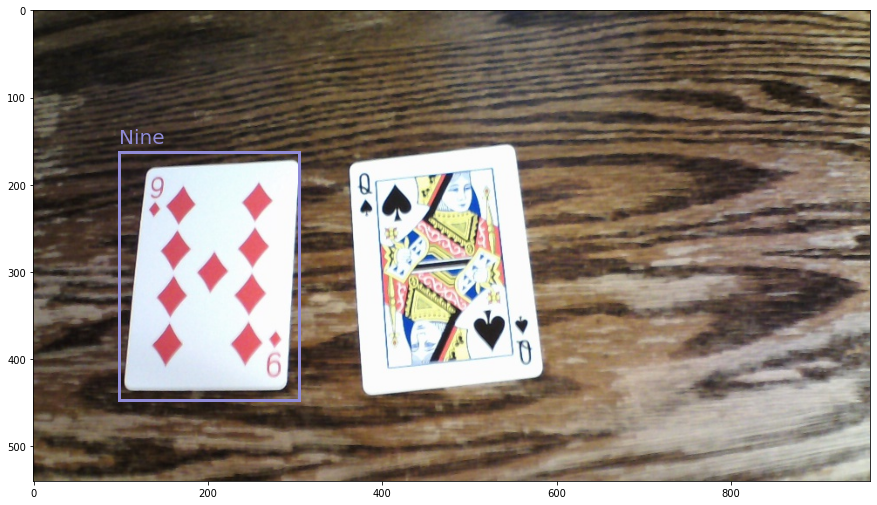

In [141]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import json
IMAGE_SIZE = (18, 12)
plt.figure(figsize=IMAGE_SIZE)
img_np = mpimg.imread(sample_image)
img = Image.fromarray(img_np.astype("uint8"), "RGB")
x, y = img.size
fig, ax = plt.subplots(1, figsize=(15, 15))
# Display the image
ax.imshow(img_np)
# draw box and label for each detection
detections = json.loads(resp)
for detect in detections[0]["boxes"]:
    label = detect["label"]
    box = detect["box"]
    conf_score = detect["score"]
    if conf_score > 0.6:
        ymin, xmin, ymax, xmax = (
            box["topY"],
            box["topX"],
            box["bottomY"],
            box["bottomX"],
        )
        topleft_x, topleft_y = x * xmin, y * ymin
        width, height = x * (xmax - xmin), y * (ymax - ymin)
        print(
            "{}: [{}, {}, {}, {}], {}".format(
                detect["label"],
                round(topleft_x, 3),
                round(topleft_y, 3),
                round(width, 3),
                round(height, 3),
                round(conf_score, 3),
            )
        )
        color = np.random.rand(3)  #'red'
        rect = patches.Rectangle(
            (topleft_x, topleft_y),
            width,
            height,
            linewidth=3,
            edgecolor=color,
            facecolor="none",
        )
        ax.add_patch(rect)
        plt.text(topleft_x, topleft_y - 10, label, color=color, fontsize=20)
plt.show()